## **Analytic Antipodal Grasps**

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from pydrake.all import (
    Evaluate,
    Jacobian,
    MathematicalProgram,
    Solve,
    Variable,
    atan,
    cos,
    eq,
    sin,
)

from manipulation import running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Introduction to Symbolic Differentiation 

For this assignment, you will need [symbolic differentiation](https://en.wikipedia.org/wiki/Computer_algebra), supported by Drake's symbolic library. We will demonstrate how to use it with a simple function: 
$$T=\cos^2(x) + y^5$$

and it's Jacobian (first-order derivative), 
$$J = \begin{pmatrix} \frac{\partial T}{\partial x} & \frac{\partial T}{\partial y} \end{pmatrix}=\begin{pmatrix} -2\cos(x)\sin(x) & 5y^4 \end{pmatrix}$$

as well as the Hessian (second-order derivative), 
$$H = \begin{pmatrix} \frac{\partial^2 T}{\partial x^2} & \frac{\partial^2 T}{\partial x \partial y} \\ \frac{\partial^2 T}{\partial y \partial x} & \frac{\partial^2 T}{\partial y^2} \end{pmatrix}=\begin{pmatrix} 2 \sin^2(x) - 2\cos^2(x) & 0 \\ 0 & 20y^3 \end{pmatrix}$$

Below are some snippets of how to define symbolic variables, differentiate expressions, and evaluate them using numerical values. 

In [2]:
# 1. Symbolic variables are defined
x = Variable("x")
y = Variable("y")

# 2. Expressions can be written by composing operations on Variables.
T = cos(x) ** 2.0 + y**5.0
print(T)

# 3. Use Evaluate to query the numerical value of the expression given the variable values.
# Use function for multi-dimensional quantities
print(Evaluate(np.array([T]), {x: 3.0, y: 5.0}))
# Use method for scalar quantities
print(T.Evaluate({x: 3.0, y: 5.0}))

# 4. Differentiate a quantity using Jacobian, or Differentiate.
J = np.array([T.Differentiate(x), T.Differentiate(y)])
print(J)
# Use method for scalar quantities
J = T.Jacobian([x, y])
print(J)
print(Evaluate(J, {x: 3.0, y: 5.0}))

# Use function for taking Jacobian of multi-dimensional quantities.
H = Jacobian(J, [x, y])
print(H)
print(Evaluate(H, {x: 3.0, y: 5.0}))

(pow(y, 5) + pow(cos(x), 2))
[[3125.98008514]]
3125.980085143325
[<Expression "(-2 * sin(x) * cos(x))"> <Expression "(5 * pow(y, 4))">]
[<Expression "(-2 * sin(x) * cos(x))"> <Expression "(5 * pow(y, 4))">]
[[2.79415498e-01]
 [3.12500000e+03]]
[[<Expression "(2 * pow(sin(x), 2) - 2 * pow(cos(x), 2))">
  <Expression "0">]
 [<Expression "0"> <Expression "(20 * pow(y, 3))">]]
[[-1.92034057e+00  0.00000000e+00]
 [ 0.00000000e+00  2.50000000e+03]]


Are the symbolic values of the Jacobian and Hessian what you expect? 

## The Cycloidal Gear

Now we enter the main part of the problem. 

After graduating from MIT, you decide to work at a company producing cutting-edge [hypercycloidal gears](https://youtu.be/MBWkibie_5I?t=74). You are in charge of designing a robotic pick-and-place system for these parts. In order to reliably grasp the gears, you decide to use your knowledge of antipodal points. 

The mechanical design department gave you a pretty ugly parametric equation for what the shape looks like, which we won't even bother writing in latex! Instead, we provided it via the function `shape`. 

Given a angle in polar coordinates (parameter $t$), it returns $p(t)=[x(t),y(t)]$, a position in 2D.  

The below cell implements the function and shows you what the gear part looks like. 

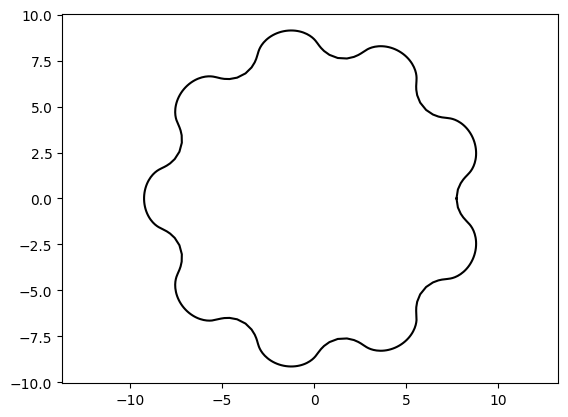

In [3]:
def shape(t: float) -> np.ndarray:
    x = (
        (10 * cos(t))
        - (1.5 * cos(t + atan(sin(-9 * t) / ((4 / 3) - cos(-9 * t)))))
        - (0.75 * cos(10 * t))
    )
    y = (
        (-10 * sin(t))
        + (1.5 * sin(t + atan(sin(-9 * t) / ((4 / 3) - cos(-9 * t)))))
        + (0.75 * sin(10 * t))
    )
    return np.array([x, y])


def plot_gear() -> None:
    theta = np.linspace(0, 2 * np.pi, 500)
    gear_shape = []
    for i in range(500):
        gear_shape.append(Evaluate(shape(theta[i])).squeeze())
    gear_shape = np.array(gear_shape)
    plt.axis("equal")
    plt.plot(gear_shape[:, 0], gear_shape[:, 1], "k-")


plot_gear()

## Grasp Energy Function

How can we analytically find a pair of antipodal points given the parametric equation of a shape? We make the following claim: 

**Claim**: Let $p(t_1)$ and $p(t_2)$ be a pair of antipodal points given in parametric space. Then $t_1$ and $t_2$ are critical points of the following energy function:
$$E=\frac{1}{2}\kappa\|p(t_1)-p(t_2)\|^2$$

that is, they satisfy $\frac{\partial E}{\partial \mathbf{t}}=[0, 0]$ where $\mathbf{t}=[t_1,t_2]$. 

For the subsequent problems, you may assume $\kappa=2$. 

Claim: If $p(t_1)$ and $p(t_2)$ are antipodal points, then

$\frac{\partial E}{\partial \mathbf{t}} = [0,0]$.

**Please answer the following questions in Gradescope.**

⸻

## Verification 1

Why does $\frac{\partial E}{\partial \mathbf{t}} = [0,0]$ hold when $p(t_1)$ and $p(t_2)$ are antipodal?

A. Because $(p(t_1)-p(t_2))$ lies along the tangent vector at both points.

B. Because $(p(t_1)-p(t_2))$ is orthogonal to the tangent vectors $p’(t_1)$ and $p’(t_2)$.

C. Because $p(t_1) = p(t_2)$, so the difference vector vanishes.

D. Because the derivative of $E$ with respect to $\mathbf{t}$ is always zero, regardless of $(t_1,t_2)$.

⸻

## Verification 2

Why does the converse (i.e., $\frac{\partial E}{\partial \mathbf{t}} = [0,0]$ implies antipodal points) not necessarily hold?

A. Because the condition also holds if $p(t_1) = p(t_2)$, which does not represent distinct antipodal points.

B. Because tangent vectors cannot be computed when $\kappa = 2$.

C. Because the gradient is never defined for parametric shapes.

D. Because the condition only applies to convex shapes.

## Implementation

**Problem 5.1.c** [4pts]
Using this knowledge, we will write a Mathematical Program to find the antipodal points. Since we are looking for $t_1$ and $t_2$ such that the Jacobians is a zero vector, we are solving a root finding problem. Problems of this nature can still be transcribed as an instance of a Mathematical program;  it simply doesn't have a cost. 

We will write down our problem as follows: 

$$\begin{aligned} \text{find} \quad & \mathbf{t}  \\ \text{s.t.} \quad &  \frac{\partial E}{\partial \mathbf{t}}(\mathbf{t}) = \mathbf{0} \\ \quad & 0 \leq \mathbf{t} \leq 2\pi - \varepsilon  \\ \quad & t_1 - t_2 \geq \varepsilon \end{aligned}$$

The first constraint makes sure that they are critical points of the energy function, while the last two makes sure the points are not overlapping. You will write the following outer loop to check for the validity of solutions.

1. Pick a random guess for $\mathbf{t}$ using [SetInitialGuess](https://drake.mit.edu/doxygen_cxx/classdrake_1_1solvers_1_1_mathematical_program.html#ae48cb6d2263ccf09e38932dcd27f769f) by uniform sampling over $[0, 2\pi - \varepsilon]$ (use `np.random.rand(2)`). 
2. Using `MathematicalProgram`, solve the above problem. Remember there is no cost in this problem, so we simply only add the constraints. 
3. If the solution is not valid (i.e. problem doesn't return success), repeat 1-2 with random guesses until a valid solution is found. 
4. If a valid solution $\mathbf{t}^*$ is found, return the Eigenvalues of the Hessian of $E$ at $\mathbf{t}^*$. (Use `np.linalg.eigvals`)

In [105]:
def find_antipodal_pts(shape: Callable) -> tuple[np.ndarray, np.ndarray]:
    """
    Finds antipodal points given the parametric function that describes the shape of the object.
    Args:
      - shape: function from parametric space t to position R2.
    Returns:
      - result: 2-dim np array [t1, t2]
      - H_eig:  2-dim np array with eigenvalues of the Hessian of E at [t1, t2]
    """
    eps = 1e-3  # do not modify

    # E(t1,t2) = ||p(t1) - p(t2)||^2  (equivalent to 0.5*kappa*||d||^2 with kappa=2)
    def energy(tt):
        t1, t2 = tt[0], tt[1]
        p1 = np.asarray(shape(t1))  # length-2, may contain AutoDiffXd
        p2 = np.asarray(shape(t2))
        d = p1 - p2
        return (d[0]*d[0] + d[1]*d[1])

    # Central-difference gradient that works on AutoDiffXd by not casting.
    def grad_num(tt):
        x = np.array([tt[0], tt[1]], dtype=object)  # keep type (AutoDiffXd during Solve)
        h = 1e-6
        g0 = (energy(x + np.array([h, 0.0], dtype=object)) - energy(x - np.array([h, 0.0], dtype=object))) / (2.0*h)
        g1 = (energy(x + np.array([0.0, h], dtype=object)) - energy(x - np.array([0.0, h], dtype=object))) / (2.0*h)
        return np.array([g0, g1], dtype=object)

    # Program: find t s.t. grad_num(t) == 0, with bounds and separation.
    prog = MathematicalProgram()
    t = prog.NewContinuousVariables(2, "t")  # [t1, t2]

    prog.AddConstraint(lambda z: grad_num(z), np.zeros(2), np.zeros(2), t)

    ub = 2.0 * np.pi - eps
    prog.AddBoundingBoxConstraint(0.0, ub, t)  # 0 ≤ t ≤ 2π - ε
    # t1 - t2 ≥ ε  (use a large finite upper bound)
    prog.AddLinearConstraint(np.array([[1.0, -1.0]]), np.array([eps]), np.array([1e6]), t)

    # Random restarts help SNOPT
    solved = False
    for _ in range(16):
        guess = np.random.rand(2) * (ub - eps)
        if guess[0] - guess[1] < eps:
            guess[0] = min(guess[1] + 2.0*eps, ub)
        prog.SetInitialGuess(t, guess)
        res = Solve(prog)
        if res.is_success():
            sol = res.GetSolution(t).astype(float)
            solved = True
            break

    if not solved:
        # deterministic try
        prog.SetInitialGuess(t, np.array([0.7, 3.4]))
        res = Solve(prog)
        if not res.is_success():
            return np.array([np.nan, np.nan]), np.array([np.nan, np.nan])
        sol = res.GetSolution(t).astype(float)

    # ---------- NEW: sanitize solution so Evaluate(shape(t)) is safe ----------
    def eval_is_finite(t_scalar: float) -> bool:
        try:
            # Try exactly what the provided helper will do:
            val = Evaluate(shape(t_scalar))
            arr = np.asarray(val, dtype=float).squeeze()
            return np.all(np.isfinite(arr))
        except Exception:
            return False

    # wrap into [0, 2π)
    sol = np.mod(sol, 2.0*np.pi)

    # if a t lands on a singular angle for your shape, nudge it by tiny deltas
    deltas = [1e-8, -1e-8, 3e-8, -3e-8, 1e-7, -1e-7, 3e-7, -3e-7, 1e-6, -1e-6, 5e-6, -5e-6]
    for i in range(2):
        if not eval_is_finite(sol[i]):
            for d in deltas:
                cand = sol[i] + d
                # keep in [0, 2π)
                if cand < 0.0:
                    cand += 2.0*np.pi
                elif cand >= 2.0*np.pi:
                    cand -= 2.0*np.pi
                if eval_is_finite(cand):
                    sol[i] = cand
                    break

    # re-enforce minimal separation (with a tiny cushion) if our nudges closed the gap
    min_gap = 2.0 * eps
    if sol[0] - sol[1] < min_gap:
        # push t1 forward a hair (wrap-safe)
        sol[0] = (sol[1] + min_gap) % (2.0*np.pi)

    # -------------------------------------------------------------------------

    # Numeric Hessian (on floats) for eigenvalues
    def energy_float(xx):
        return float(energy(xx))

    x = sol.copy()
    h = 1e-5
    H = np.zeros((2, 2), dtype=float)
    for i in range(2):
        ei = np.zeros(2); ei[i] = 1.0
        H[i, i] = (energy_float(x + h*ei) - 2.0*energy_float(x) + energy_float(x - h*ei)) / (h*h)
        for j in range(i+1, 2):
            ej = np.zeros(2); ej[j] = 1.0
            fpp = energy_float(x + h*ei + h*ej)
            fpm = energy_float(x + h*ei - h*ej)
            fmp = energy_float(x - h*ei + h*ej)
            fmm = energy_float(x - h*ei - h*ej)
            H[i, j] = H[j, i] = (fpp - fpm - fmp + fmm) / (4.0*h*h)

    H = 0.5*(H + H.T)
    H_eig = np.linalg.eigvalsh(H)

    return sol, H_eig


You can run the cell below to check the correctnes of your implementation. As the constraint is nonlinear, it might take some time to compute. (Typically, the solve time will still be less than 2~3 seconds).

[-1312.08409471 -1025.65550719]


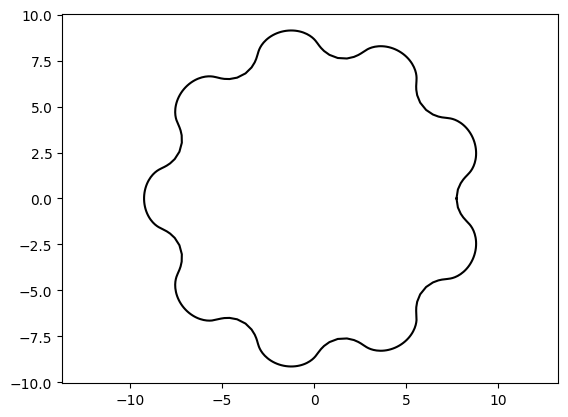

In [106]:
def get_antipodal_pts_on_shape(pts, shape):
    antipodal_pts = []
    for i in range(2):
        val = Evaluate(shape(pts[i])).squeeze()
        antipodal_pts.append(val)
    antipodal_pts = np.array(antipodal_pts)
    return antipodal_pts


def plot_antipodal_pts(pts, shape):
    antipodal_pts = get_antipodal_pts_on_shape(pts, shape)
    plt.scatter(antipodal_pts[:, 0], antipodal_pts[:, 1], color="red")


plot_gear()
result, H_eig = find_antipodal_pts(shape)
# plot_antipodal_pts(result, shape)
print(H_eig)

In [107]:
# Use this to test your implementation if you want!
from manipulation.exercises.clutter.test_analytic_grasp import TestAnalyticGrasp
from manipulation.exercises.grader import Grader

Grader.grade_output([TestAnalyticGrasp], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 4/4.

Score for Test find_antipodal_pts is 4/4.


## Verification 3: Finding antipodal points

Implement the exercises below. Copy the exact numerical values (to 4 decimal places) for your verification keys, which you can copy/paste to Gradescope.

Set a random seed with `np.random.seed(42)` and find anti-podal point in the shape under this random seed. (It's important to set the random seed first so that the result is reproducible)


**Question:** What are the antipodal grasp locations $[t1, t2]$ and the eigenvalues of the Hessian?

In [108]:
np.random.seed(42)
find_antipodal_pts(shape)

np.random.seed(42)
result, H_eig = find_antipodal_pts(shape)
print(np.round(result, 4), np.round(H_eig, 4))


[5.1269 1.1562] [-1312.0841 -1025.6555]


## Hessian Analysis

Why did we implement the Hessian? You may remember that the Hessian is used for the second-derivative test. For a function $f(x)$ with a critical point $x^*$, this critical point is:
- A local minima if the Hessian is positive-definite (i.e. all positive eigenvalues)
- A local maxima if the Hessian is negative-definite (i.e. all negative eigenvalues)
- A saddle point if the Hessian has mixed positive / negative eigenvalues. 

**Please answer the following questions in Gradescope.**

## Verification 4

What do local minima, maxima, and saddle points correspond to in terms of the geometry of the object?

A. Local minima $\to$ convex points, local maxima $\to$ concave points, saddle points $\to$ flat regions.

B. Local minima $\to$ concave points, local maxima $\to$ convex points, saddle points $\to$ one concave and one convex.

C. Local minima $\to$ flat regions, local maxima $\to$ edges, saddle points $\to$ corners.

D. Local minima $\to$ random points, local maxima $\to$ sharp corners, saddle points $\to$ curved edges.

## Verification 5

Why might one configuration be preferred over the others for grasping?

A. Local maxima are most desirable because convex regions prevent penetration into the object.

B. Saddle points are most desirable because mixing concave and convex directions prevents slipping.

C. All three are equally good because stability does not depend on geometry.

D. Local minima are most desirable because concave regions provide stability against disturbances.

**HINT: The cell below will visualize each of the cases.**

In [ ]:
if running_as_notebook:
    plt.subplot(1, 3, 1)
    plot_gear()
    plt.title("Local Minima")
    np.random.seed(45)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig > 0).all():
            break
    plot_antipodal_pts(result, shape)

    plt.subplot(1, 3, 2)
    plot_gear()
    plt.title("Local Maxima")
    np.random.seed(4)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig < 0).all():
            break
    plot_antipodal_pts(result, shape)

    plt.subplot(1, 3, 3)
    plot_gear()
    plt.title("Saddle Point")
    np.random.seed(13)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig[0] > 0) and (H_eig[1] < 0):
            break
    plot_antipodal_pts(result, shape)